In [1]:
import os

import nibabel as nib
import numpy as np
import pandas as pd

global fig
%matplotlib widget
%matplotlib inline

from skopt.utils import use_named_args, cook_initial_point_generator
from skopt.space import Integer
from skopt import gp_minimize

########################
### Custom functions ###
########################
from src.loss_func import DC, get_yield, hellinger_distance
from src.phos_elect import create_grid, implant_grid, get_phosphenes
### needed for matrix rotation/translation ect
from src.ninimplant import get_xyz
import src.utils as utils
import src.visualizations as visualizations

import src.generate_visual_sectors as gvs

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# added because: "invalid value encountered in True-divide"
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [2]:
CONFIG = utils.read_config("/home/odysseas/Desktop/UU/thesis/BayesianOpt/check_target_maps_10x10x10/config.json")
# determine range of parameters
DIM1 = Integer(name='alpha', low=-90, high=90)  # visual degrees
DIM2 = Integer(name='beta', low=-15, high=110)  # visual degrees - -15 is probably lowest possible angle, otherwise other hem is in the way if hem = RH -> low = -110, high = 15
DIM3 = Integer(name='offset_from_base', low=0, high=40)     # in mm
DIM4 = Integer(name='shank_length', low=10, high=20)    # in mm
DIMENSIONS = [DIM1, DIM2, DIM3, DIM4]
X0 = (CONFIG["INIT_ALPHA"], CONFIG["INIT_BETA"], CONFIG["INIT_OFFSET_FROM_BASE"], CONFIG["INIT_SHANK_LENGTH"])

In [3]:
@use_named_args(dimensions=DIMENSIONS)
def f(alpha, beta, offset_from_base, shank_length):
    """This function encapsulates the electrode placement procedure and returns the cost value by
    comparing the resulting phosphene map with the target map. By the design of skopt, it can
    only take the objective function's parameters as arguments, so other variables used within
    the function should be defined as global.

    * First it creates a grid based on the four parameters.
    * Phosphenes are generated based on the grid's contact points,
      and their sizes are determined using cortical magnification and spread values.
    * These phosphenes are converted into a 2D image representation.
      The function then computes the dice coefficient and yield, and calculates
      the Hellinger distance between the generated image and a target density.
    * The resulting cost is a combination of these factors,
      with penalties applied if the grid is invalid.
    * The function also handles cases of invalid values and prints diagnostic information.

    Parameters
    ----------
    The decorators @use_named_args allows to call the function without
    specifying the parameters, since dimensions is a list with the parameters.

    Returns
    -------
    int or float
        The calculated cost used by the bayesopt algorithm
    """
    global CONFIG
    # global variables defined in main
    global start_location, gm_mask, target_density, bin_thresh
    # global coordinates and maps from the mri scans defined in main
    global good_coords, good_coords_V1, polar_map, ecc_map, sigma_map
    # global variables related to the previous array
    global iter_count, total_contacts_xyz_moved, valid_grids, overlap_valid_grids
    global arr_current, optimized_arrays_from_f_manual
    # cost functions
    global arr_dices, total_dices, arr_yields, total_yields, arr_HDs, total_HDs, arr_costs, total_costs

    grid_valid_overlap = True
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)

    # create grid
    orig_grid = create_grid(start_location, shank_length, CONFIG["N_CONTACTPOINTS_SHANK"], CONFIG["N_COMBS"],
                            CONFIG["N_SHANKS_PER_COMB"], CONFIG["SPACING_ALONG_XY"], offset_from_origin=0)

    # implanting grid
    all_output = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)
    cur_contacts_xyz_moved, grid_valid_convex_hull = all_output[1], all_output[-1]

    if arr_current <= 1:
        new_contacts_xyz_moved = cur_contacts_xyz_moved
        grid_valid = grid_valid_convex_hull
    else:
        new_contacts_xyz_moved = np.hstack((total_contacts_xyz_moved, cur_contacts_xyz_moved))
        grid_valid_overlap = utils.get_overlap_validity(optimized_arrays_from_f_manual, cur_contacts_xyz_moved, CONFIG)
        grid_valid = grid_valid_overlap and grid_valid_convex_hull

    overlap_valid_grids.append(grid_valid_overlap)
    valid_grids.append(grid_valid)

    # get angle, ecc and rfsize for contactpoints (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)
    new_phosphenes_V1 = get_phosphenes(new_contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    array_phosphenes_V1 = get_phosphenes(cur_contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)

    phosphene_map = utils.get_phosphene_map(new_phosphenes_V1, CONFIG)
    phosphene_map_array = utils.get_phosphene_map(array_phosphenes_V1, CONFIG)

    # compute dice coefficient -> should be 1 -> invert cost
    dice, im1, im2 = DC(target_density, phosphene_map_array, bin_thresh)
    par1 = 1.0 - (CONFIG["A"] * dice)
    arr_dices.append(dice)

    total_dice, _, _ = DC(target_density, phosphene_map, bin_thresh)
    par1_total = 1.0 - (CONFIG["A"] * total_dice)
    total_dices.append(total_dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(cur_contacts_xyz_moved, good_coords)

    grid_yield_total = get_yield(new_contacts_xyz_moved, good_coords)
    total_yields.append(grid_yield_total)

    # compute hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phosphene_map_array.flatten(), target_density.flatten())
    hell_d_total = hellinger_distance(phosphene_map.flatten(), target_density.flatten())

    if np.isnan(phosphene_map_array).any() or np.sum(phosphene_map_array) == 0:
        par1 = 1

    ####### added the first conditional to prevent lower cost functions for empty array #######
    if dice == 0.0 or np.isnan(phosphene_map).any() or np.sum(phosphene_map) == 0:
        par1_total = 1

    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
    else:
        par3 = CONFIG["C"] * hell_d

    if dice == 0 or par3 == 1:
        grid_yield = 0
    par2 = 1.0 - (CONFIG["B"] * grid_yield)
    arr_yields.append(grid_yield)

    ####### added the first conditional to prevent lower cost functions for empty array #######
    if hell_d == 1.0 or np.isnan(hell_d_total) or np.isinf(hell_d_total):
        par3_total = 1
    else:
        par3_total = CONFIG["C"] * hell_d_total

    arr_HDs.append(hell_d)
    total_HDs.append(hell_d_total)

    # combine cost functions
    cost = par1 + par2 + par3
    cost_total = par1_total + par2 + par3_total

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
        # always include the array specific yield
        cost_total = par1_total + penalty + par2 + penalty + par3_total + penalty

    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3

    if np.isnan(cost_total) or np.isinf(cost_total):
        cost_total = 3

    arr_costs.append(cost)
    total_costs.append(cost_total)

    # print(f"overlap valid: {grid_valid_overlap} / convex hull valid: {grid_valid_convex_hull} / "
    #       f"cost: {cost} / total cost: {cost_total}")
    # print(f"dice: {round(dice, 5)} / total dice: {round(total_dice, 5)} / yield: {round(grid_yield, 5)} / "
    #       f"total yield: {round(grid_yield_total, 5)} / HD: {round(par3, 5)} / total HD: {round(par3_total, 5)}", end="\n")

    iter_count += 1
    if iter_count % 25 == 0:
        print("Now at iteration:", iter_count, "out of", CONFIG["NUM_CALLS"])

    return cost_total

def f_manual(alpha, beta, offset_from_base, shank_length, good_coords, good_coords_V1, target_density):
    """
    Copy from f, to get phosphene map and contact points for the optimized parameters. Used to visualize results.
    """
    global CONFIG
    # global variables defined in main
    global start_location, gm_mask, bin_thresh
    # global coordinates and maps from the mri scans defined in main
    global polar_map, ecc_map, sigma_map
    # global variables related to the previous array
    global iter_count, total_contacts_xyz_moved
    global arr_current, optimized_arrays_from_f_manual
    global best_dc, best_hd

    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)

    # create grid
    orig_grid = create_grid(start_location, shank_length, CONFIG["N_CONTACTPOINTS_SHANK"], CONFIG["N_COMBS"],
                            CONFIG["N_SHANKS_PER_COMB"], CONFIG["SPACING_ALONG_XY"], offset_from_origin=0)

    # implanting grid
    ref_contacts_xyz, best_contacts_xyz_moved, refline, refline_moved, projection, ref_orig, ray_visualize, new_location, grid_valid_convex_hull = implant_grid(
        gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    if arr_current <= 1:
        new_contacts_xyz_moved = best_contacts_xyz_moved
        grid_valid = grid_valid_convex_hull
    else:
        new_contacts_xyz_moved = np.hstack((total_contacts_xyz_moved, best_contacts_xyz_moved))
        grid_valid_overlap = utils.get_overlap_validity(optimized_arrays_from_f_manual, best_contacts_xyz_moved, CONFIG)
        grid_valid = grid_valid_overlap and grid_valid_convex_hull

    # get angle, ecc and rfsize for contactpoints in each ROI (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)
    new_phosphenes_V1 = get_phosphenes(new_contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    array_phosphenes_V1 = get_phosphenes(best_contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)

    phosphene_map = utils.get_phosphene_map(new_phosphenes_V1, CONFIG)
    phosphene_map_array = utils.get_phosphene_map(array_phosphenes_V1, CONFIG)

    # compute dice coefficient -> should be large -> invert cost
    arr_dice, im1, im2 = DC(target_density, phosphene_map_array, bin_thresh)

    if not grid_valid or arr_dice == 0.0:
        return [grid_valid, arr_dice]

    total_dice, _, _ = DC(target_density, phosphene_map, bin_thresh)
    par1_total = 1.0 - (CONFIG["A"] * total_dice)

    prop_total_dice = total_dice / best_dc

    # compute yield -> should be 1 -> invert cost
    arr_yield = get_yield(best_contacts_xyz_moved, good_coords)
    total_yield = get_yield(new_contacts_xyz_moved, good_coords)

    # compute Hellinger distance -> should be small -> keep cost
    arr_hd = hellinger_distance(phosphene_map_array.flatten(), target_density.flatten())
    total_hd = hellinger_distance(phosphene_map.flatten(), target_density.flatten())

    prop_total_hd = (1 - total_hd) / (1 - best_hd)

    ## validations steps
    ####### added the first conditional to prevent lower cost functions for empty array #######
    if arr_dice == 0.0 or np.isnan(phosphene_map).any() or np.sum(phosphene_map) == 0:
        par1_total = 1

    if np.isnan(arr_hd) or np.isinf(arr_hd):
        par3 = 1
    else:
        par3 = CONFIG["C"] * arr_hd

    if arr_dice == 0 or par3 == 1:
        arr_yield = 0
    par2 = 1.0 - (CONFIG["B"] * arr_yield)

    ####### added the first conditional to prevent lower cost functions for empty array #######
    if arr_hd == 1.0 or np.isnan(total_hd) or np.isinf(total_hd):
        par3_total = 1
    else:
        par3_total = CONFIG["C"] * total_hd

    # combine cost functions
    cost = par1_total + par2 + par3_total
    best_cost = best_dc + 0 + best_hd
    highest_cost = 3
    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1_total + penalty + par2 + penalty + par3_total + penalty

    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3

    # the proportion of the cost compared to the best possible cost
    prop_cost = 1 - ((cost - best_cost) / (highest_cost - best_cost))

    return [grid_valid, arr_dice, total_dice, prop_total_dice, arr_hd, total_hd, prop_total_hd, arr_yield, total_yield,
            cost, prop_cost, array_phosphenes_V1, new_phosphenes_V1,
            best_contacts_xyz_moved, phosphene_map_array, phosphene_map, new_contacts_xyz_moved]

In [4]:
print(f"configuration:\n"
      f"{CONFIG['N_COMBS']} x {CONFIG['N_SHANKS_PER_COMB']} x {CONFIG['N_CONTACTPOINTS_SHANK']} for {CONFIG['NUM_CALLS']} iterations")
RESULTS_PATH = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/check_target_maps_10x10x10/results/"
# set file names
FNAME_ANG = "inferred_angle.mgz"
FNAME_ECC = "inferred_eccen.mgz"
FNAME_SIGMA = "inferred_sigma.mgz"
FNAME_APARC = "aparc+aseg.mgz"
FNAME_LABEL = "inferred_varea.mgz"
# lists of target maps to loop through
TARGETS = ([gvs.upper_sector(windowsize=CONFIG["WINDOWSIZE"], fwhm=800, radiusLow=0, radiusHigh=500, plotting=False),
            gvs.lower_sector(windowsize=CONFIG["WINDOWSIZE"], fwhm=800, radiusLow=0, radiusHigh=500, plotting=False),
            gvs.inner_ring(windowsize=CONFIG["WINDOWSIZE"], fwhm=400, radiusLow=0, radiusHigh=250, plotting=False),
            gvs.complete_gauss(windowsize=CONFIG["WINDOWSIZE"], fwhm=1200, radiusLow=0, radiusHigh=500, center=None, plotting=False)])

TARGET_NAMES = (["upper_target", "lower_target", "inner_target", "full_target"])
def run(sub):
    global start_location, gm_mask, target_density, bin_thresh
    global arr_current, total_contacts_xyz_moved, optimized_arrays_from_f_manual
    global overlap_valid_grids, valid_grids, iter_count
    global good_coords, good_coords_V1, polar_map, ecc_map, sigma_map
    # cost functions
    global arr_dices, total_dices, arr_yields, total_yields, arr_HDs, total_HDs, arr_costs, total_costs
    global best_dc, best_hd

    dim1 = Integer(name='alpha', low=-90, high=90)  # visual degrees
    # set beta angle range according to hemisphere
    dim2_lh = Integer(name="beta", low=-15, high=110)
    dim2_rh = Integer(name="beta", low=-110, high=15)
    dim3 = Integer(name='offset_from_base', low=0, high=40)  # in mm
    dim4 = Integer(name='shank_length', low=10, high=20)    # in mm
    
    for targ_name, target in zip(TARGET_NAMES, TARGETS):
        target_density = target
        print(f"Now at {targ_name}")
    
        target_density /= target_density.max()
        target_density /= target_density.sum()
        bin_thresh = np.percentile(target_density, CONFIG["DC_PERCENTILE"])
        data_dir = f"/home/odysseas/Desktop/UU/thesis/BayesianOpt/input_processed_data_HCP/{sub}/T1w/mri/"
        if sub == "fsaverage":
            data_dir = f"/home/odysseas/Desktop/UU/thesis/BayesianOpt/input_processed_data_HCP/{sub}/"
    
        # actually load data
        ang_img = nib.load(data_dir + FNAME_ANG)
        polar_map = ang_img.get_fdata()
        ecc_img = nib.load(data_dir + FNAME_ECC)
        ecc_map = ecc_img.get_fdata()
        sigma_img = nib.load(data_dir + FNAME_SIGMA)
        sigma_map = sigma_img.get_fdata()
        aparc_img = nib.load(data_dir + FNAME_APARC)
        aparc_roi = aparc_img.get_fdata()
        label_img = nib.load(data_dir + FNAME_LABEL)
        label_map = label_img.get_fdata()
    
        # compute valid voxels
        dot = (ecc_map * polar_map)
        good_coords = np.asarray(np.where(dot != 0.0))
    
        # filter gm per hemisphere
        cs_coords_rh = np.where(aparc_roi == 1021)
        cs_coords_lh = np.where(aparc_roi == 2021)
        gm_coords_rh = np.vstack(np.where((aparc_roi >= 1000) & (aparc_roi < 2000)))
        gm_coords_lh = np.vstack(np.where(aparc_roi > 2000))
        xl, yl, zl = get_xyz(gm_coords_lh)
        xr, yr, zr = get_xyz(gm_coords_rh)
        gm_lh = np.array([xl, yl, zl]).T
        gm_rh = np.array([xr, yr, zr]).T
    
        # extract labels
        v1_coords_rh = np.asarray(np.where(label_map == 1))
        v1_coords_lh = np.asarray(np.where(label_map == 1))
    
        set_rounded_good_coords = set(map(tuple, good_coords.T))
        set_rounded_gm_coords_rh = set(map(tuple, gm_coords_rh.T))
        set_rounded_gm_coords_lh = set(map(tuple, gm_coords_lh.T))
        set_rounded_v1_coords_lh = set(map(tuple, v1_coords_lh.T))
        set_rounded_v1_coords_rh = set(map(tuple, v1_coords_rh.T))
    
        # divide V1 coords per hemisphere
        good_coords_lh = np.array(list(set(set_rounded_good_coords) & set(set_rounded_gm_coords_lh))).T
        good_coords_rh = np.array(list(set(set_rounded_good_coords) & set(set_rounded_gm_coords_rh))).T
        v1_coords_lh = np.array(list(set(set_rounded_v1_coords_lh) & set(set_rounded_gm_coords_lh))).T
        v1_coords_rh = np.array(list(set(set_rounded_v1_coords_rh) & set(set_rounded_gm_coords_rh))).T
    
        # find center of left and right calcarine sulci
        median_lh = [np.median(cs_coords_lh[0][:]), np.median(cs_coords_lh[1][:]), np.median(cs_coords_lh[2][:])]
        median_rh = [np.median(cs_coords_rh[0][:]), np.median(cs_coords_rh[1][:]), np.median(cs_coords_rh[2][:])]
    
        # get GM mask and compute dorsal/posterior planes
        gm_mask = np.where(aparc_roi != 0)
    
        # apply optimization to each hemisphere
        for gm_mask, hem, start_location, good_coords, good_coords_V1, dim2 in zip([gm_lh, gm_rh], ["LH", "RH"],
                                                                                   [median_lh, median_rh],
                                                                                   [good_coords_lh, good_coords_rh],
                                                                                   [v1_coords_lh, v1_coords_rh],
                                                                                   [dim2_lh, dim2_rh]):
    
            print(f"SUBJECT {sub}, HEMISPHERE {hem}")
            sub_target = sub + "_" + targ_name
            utils.create_dirs(RESULTS_PATH, sub_target, hem)
    
            best_possible_phos = get_phosphenes(good_coords_V1, good_coords_V1, polar_map, ecc_map, sigma_map)
            best_possible_map = utils.get_phosphene_map(best_possible_phos, CONFIG)
    
            best_dc, _, _ = DC(target_density, best_possible_map, bin_thresh)
            best_hd = hellinger_distance(best_possible_map.flatten(), target_density.flatten())
    
            total_contacts_xyz_moved = None
            all_phosphenes = None
            total_phosphene_map = None
            optimized_arrays_from_f_manual = {}
            phosphenes_per_arr = {}
            phosphene_map_per_arr = {}
            out_df_all_results = pd.DataFrame()
            out_df_best_results = pd.DataFrame()
            dimensions = [dim1, dim2, dim3, dim4]
            # global arr_current
            arr_current = 1
            for i in range(1, CONFIG["N_ARRAYS"] + 1):
                print(f"NOW WORKING ON ARRAY {i} OUT OF {CONFIG['N_ARRAYS']} for {sub_target}, {hem}, "
                      f"AND VALID ONES SO FAR ARE {len(optimized_arrays_from_f_manual)}")
    
                arr_dices, total_dices = [], []
                arr_yields, total_yields = [], []
                arr_HDs, total_HDs = [], []
                arr_costs, total_costs = [], []
    
                iter_count = 1
                valid_grids = []
                overlap_valid_grids = []
    
                # create initial point generator
                lhs2 = cook_initial_point_generator("lhs", criterion="maximin")
    
                # optimize
                print("Starting iteration: 1")
                res = gp_minimize(f, x0=X0, dimensions=dimensions, n_jobs=1, n_calls=CONFIG["NUM_CALLS"],
                                  n_initial_points=CONFIG["NUM_INITIAL_POINTS"], initial_point_generator=lhs2,
                                  callback=[utils.custom_stopper])
    
                best_params_list = [res.x[0], res.x[1], res.x[2], res.x[3]]
    
                # print results
                print("subject ", sub_target, " ", hem)
    
                # the final array coordinates are contacts_xyz_moved
                data = f_manual(res.x[0], res.x[1], res.x[2], res.x[3], good_coords, good_coords_V1, target_density)
                grid_valid, arr_dice = data[0], data[1]
    
                print(f"The best configuration for array {i} is {'valid' if grid_valid else 'invalid'}")
                if not grid_valid or arr_dice == 0.0:
                    print(f"should skip array {i} because it is invalid or phosphene map is empty")
                    continue
    
                (total_dice, prop_total_dice, arr_hd, total_hd, prop_total_hd, arr_yield, total_yield,
                 cost, prop_cost, arr_phosphenes, all_phosphenes, contacts_xyz_moved,
                 arr_phosphene_map, total_phosphene_map, total_contacts_xyz_moved) = data[2:]
    
                optimized_arrays_from_f_manual[arr_current] = contacts_xyz_moved
                phosphenes_per_arr[arr_current] = arr_phosphenes
                phosphene_map_per_arr[arr_current] = arr_phosphene_map
                # print("best dice, best total dice, best yield, best total yield, best total cost:", arr_dice,
                #       total_dice, arr_yield, total_yield, cost)
                # print("best HD, best total HD:", arr_hd, total_hd)
                # print("prop total dice, prop total hd, prop cost", prop_total_dice, prop_total_hd, prop_cost)
    
                visualizations.visualize_array_map(arr_phosphene_map, total_phosphene_map, hem)
                print("*" * 35)
                print("FINISHED ARRAY", arr_current)
                print("*" * 35)
    
                df_arr = utils.get_arr_df(arr_current, arr_dices, total_dices, arr_yields, total_yields, arr_HDs,
                                    total_HDs, arr_costs, total_costs, CONFIG["NUM_CALLS"])
                df_best = utils.get_best_df_10x10x10(arr_current, arr_dice, total_dice, prop_total_dice, arr_yield, total_yield,
                                      arr_hd, total_hd, prop_total_hd, cost, prop_cost, best_params_list)

                out_df_all_results = pd.concat([out_df_all_results, df_arr], axis=0, ignore_index=True)
                out_df_best_results = pd.concat([out_df_best_results, df_best], axis=0, ignore_index=True)
                arr_current += 1

            pickle_data = [optimized_arrays_from_f_manual, phosphenes_per_arr, phosphene_map_per_arr,
                           total_contacts_xyz_moved, all_phosphenes, total_phosphene_map]

            utils.write_results(out_df_all_results, RESULTS_PATH, sub_target, hem, "all")
            utils.write_results(out_df_best_results, RESULTS_PATH, sub_target, hem, "best")

            utils.write_results_pickle(RESULTS_PATH, sub_target, hem, pickle_data)
            utils.write_params(RESULTS_PATH, sub_target, hem, CONFIG)
    
            # visualize and save maps
            visualizations.visualize_phosphene_maps(phosphene_map_per_arr, total_phosphene_map, RESULTS_PATH, sub_target, hem, CONFIG, show=False, save=True)
            visualizations.visualize_polar_plot(all_phosphenes, RESULTS_PATH, sub_target, hem, CONFIG, show=False, save=True)
            visualizations.visualize_kde_polar_plot(all_phosphenes, RESULTS_PATH, sub_target, hem, CONFIG, show=False, save=True)

configuration:
 10 x 10 x 10 for 150 iterations


Now at upper_target
SUBJECT 109123, HEMISPHERE LH
NOW WORKING ON ARRAY 1 OUT OF 5 for 109123_upper_target, LH, AND VALID ONES SO FAR ARE 0
Starting iteration: 1
Now at iteration: 25 out of 150
Now at iteration: 50 out of 150
Now at iteration: 75 out of 150
Now at iteration: 100 out of 150
Now at iteration: 125 out of 150
Now at iteration: 150 out of 150
subject  109123_upper_target   LH
The best configuration for array 1 is valid


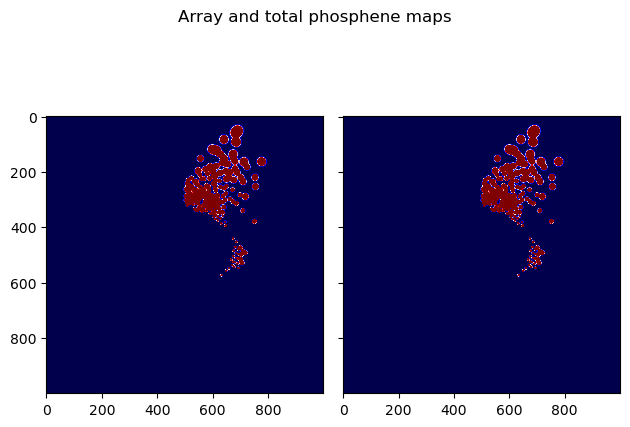

***********************************
FINISHED ARRAY 1
***********************************
NOW WORKING ON ARRAY 2 OUT OF 5 for 109123_upper_target, LH, AND VALID ONES SO FAR ARE 1
Starting iteration: 1


KeyboardInterrupt: 

In [5]:
import random

subj_list = os.listdir("/home/odysseas/Desktop/UU/thesis/BayesianOpt/input_processed_data_HCP/")
sub = random.choice(subj_list)
run(sub)

In [4]:
def read_pickle_file(sub: str, hem: str) -> list:
    """Reads the saved pickle file.

    Parameters
    ----------
    hem : str
        The hemisphere from which we want to get the pickle file

    Returns
    -------
    data : list
        [optimized_arrays_from_f_manual, phosphenes_per_arr, phosphene_map_per_arr,
        total_contacts_xyz_moved, all_phosphenes, total_phosphene_map]
    """
    import glob, pickle
    RESULTS_PATH = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/fsaverage_5_arrays_10x10x10/results/"
    dir = RESULTS_PATH + sub + "/" + hem + "/"
    filenames = glob.glob(os.path.join(dir, "*.pkl"))
    data = []
    if filenames:
        # Assuming there's only one file in the directory, you can take the first one
        filename = filenames[0]
        try:
            with open(filename, "rb") as file:
                data = pickle.load(file)
        except FileNotFoundError as e:
            print(e)
        return data

data = read_pickle_file("100610", "LH")
all_phosphenes = data[4]